### 继MATLAB之后，对生成的数据进行处理

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lb
print(lb.__version__)

0.10.2.post1


#### 读取数据

In [16]:
'''读取数据'''
import os
path = './audios'
category = 'm_cw'

#直达区回波信号
direct_path = os.path.join(path, category ,'_direct.wav') 
#第一声影区和会聚区回波
shad_1st_path, convg_1st_path = os.path.join(path,category+'_1st_shadow.wav'), os.path.join(path,category+'_1st_convergence.wav')
#第二声影区和会聚区回波
shad_2nd_path, convg_2nd_path  = os.path.join(path,category+'_2nd_shadow.wav'), os.path.join(path,category+'_2nd_convergence.wav')
#第三声影区和会聚区
shad_3rd_path, convg_3rd_path = os.path.join(path,category+'_3rd_shadow.wav'), os.path.join(path,category+'_3rd_convergence.wav')

shad_1st_echo ,sr= lb.load(shad_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_echo ,sr= lb.load(convg_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_echo,shad_1st_echo = np.array(convg_1st_echo), np.array(shad_1st_echo)

shad_2nd_echo ,sr= lb.load(shad_2nd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_2nd_echo ,sr= lb.load(convg_2nd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_2nd_echo,shad_2nd_echo = np.array(convg_2nd_echo), np.array(shad_2nd_echo)

shad_3rd_echo ,sr= lb.load(shad_3rd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_3rd_echo ,sr= lb.load(convg_3rd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_3rd_echo,shad_3rd_echo = np.array(convg_3rd_echo), np.array(shad_3rd_echo)


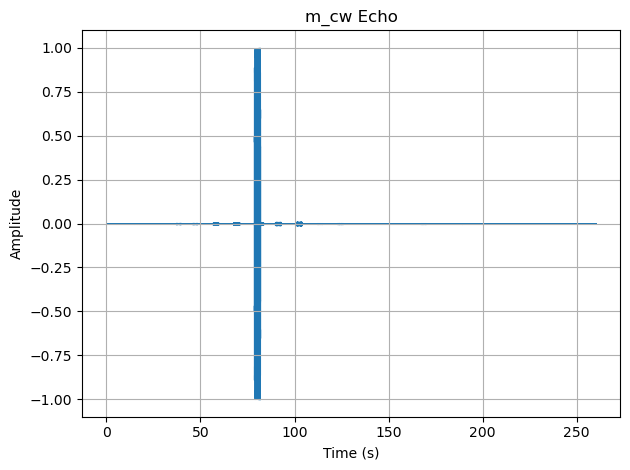

In [17]:
#读取采样率sr
sr = lb.get_samplerate(os.path.join(path, 'costas_cw_1st_shadow.wav'))
#绘制信号波形
lb.display.waveshow(convg_1st_echo, sr=sr,axis='s')
plt.title(category+' Echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

### 添加噪声

In [21]:
def awgn(x, snr, out='signal', method='vectorized', axis=0):
    '''
    添加噪声,由matlab更改而来
    https://www.cnblogs.com/minyuan/p/14078114.html
    '''
    # Signal power
    if method == 'vectorized':
        N = x.size
        Ps = np.sum(x ** 2 / N)

    elif method == 'max_en':
        N = x.shape[axis]
        Ps = np.max(np.sum(x ** 2 / N, axis=axis))

    elif method == 'axial':
        N = x.shape[axis]
        Ps = np.sum(x ** 2 / N, axis=axis)
    else:
        raise ValueError('method \"' + str(method) + '\" not recognized.')
    # Signal power, in dB
    Psdb = 10 * np.log10(Ps)
    # Noise level necessary
    Pn = Psdb - snr
    # Noise vector (or matrix)
    n = np.sqrt(10 ** (Pn / 10)) * np.random.normal(0, 1, x.shape)
    if out == 'signal':
        return x + n
    elif out == 'noise':
        return n
    elif out == 'both':
        return x + n, n
    else:
        return x + n

### 采用频域自适应滤波进行抗干扰,无作用

testing


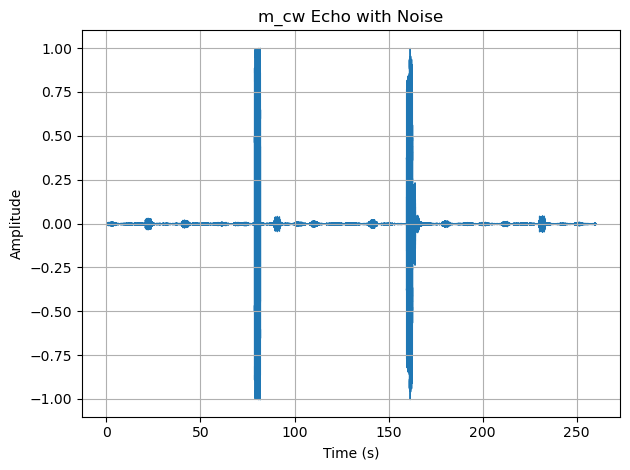

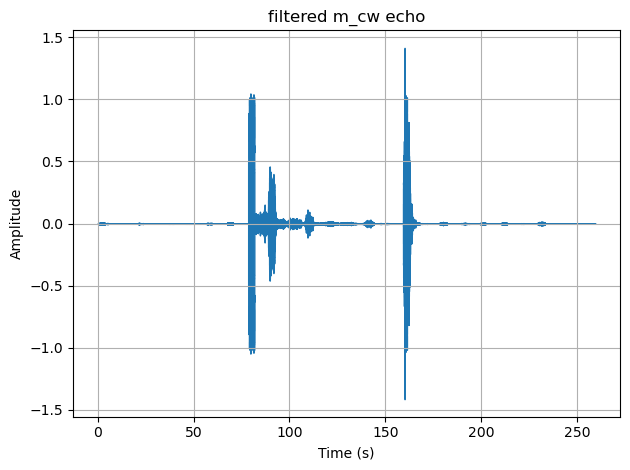

In [19]:
""" frequency domain adaptive filter """
from fdaf import fdaf 

# 设置 block 长度和移位步长
M = 2048    # block size
# x为干扰信号
x = convg_2nd_echo
d = convg_1st_echo + convg_2nd_echo
e = fdaf(x, d, M, mu=0.2, beta=0.9)
lb.display.waveshow(d, sr=sr,axis='s')
plt.title(category+' Echo with Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()
lb.display.waveshow(e, sr=sr,axis='s')
plt.title('filtered '+category+' echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

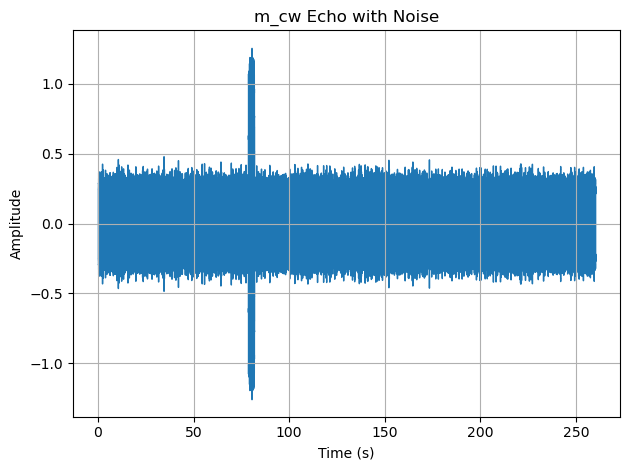

In [22]:
#添加白噪声
convg_1st_echo = awgn(convg_1st_echo,-5)
#绘制信号波形
lb.display.waveshow(convg_1st_echo, sr=sr,axis='s')
plt.title(category+' Echo with Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()


### 分帧并计算每帧能量or过零率

In [23]:
#设定帧长和帧移
frame_length ,hop_length =2048, 512

# 对音频数据进行填充（必要步骤，可确保分帧完整）
padded_y = np.pad(convg_1st_echo, (frame_length // 2, frame_length // 2), mode='reflect')

#进行分帧
frames = lb.util.frame(padded_y, frame_length=frame_length, hop_length=hop_length)

# 计算每帧的能量
frame_energies = np.sum(np.abs(frames) ** 2, axis=0)

#读取过零率
zcrs = lb.feature.zero_crossing_rate(padded_y, frame_length = frame_length, hop_length = hop_length, center = True) 

In [24]:
'''frames的每一列为一帧'''
print(len(frames[0]))
print(len(frames[:,0]))
print(f"帧数：{len(frames[0])}")
print(f"第一帧过零率：{zcrs[0,1]}")


2032
2048
帧数：2032
第一帧过零率：0.38427734375


In [25]:
max_zcr = max(zcrs[0])
max_energy = max(frame_energies)
vad_idx = []
'''结合能量检测'''
# for i,energy in enumerate(frame_energies):
#     if energy >= 0.1*max_energy:
#         vad_idx.append(i)
'''过零率检测'''
# for i,zcr in enumerate(zcrs[0]):
#     if zcr <= 0.7*max_zcr:
#         vad_idx.append(i)
'''同时结合能量和 ZCR'''
vad_idx = [i for i, (zcr, energy) in enumerate(zip(zcrs[0], frame_energies))
           if zcr >= 0.4 * max_zcr and energy >= 0.1 * max_energy]

pulse_start = (vad_idx[0]*hop_length+frame_length)/sr
pulse_end = (vad_idx[-1]*hop_length+frame_length)/sr
pulse_len = pulse_end - pulse_start

print(f'脉冲的帧索引{vad_idx}')
print(f"脉冲长度{pulse_len}s")

# 保证结束索引不超过 frames 的最大列数
end_idx = min(vad_idx[-1] + 1, frames.shape[1])
extracted_frames = frames[:, vad_idx[0]:vad_idx[-1] + 1]

脉冲的帧索引[612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639]
脉冲长度3.456000000000003s


### 根据帧重构信号

In [26]:
def overlap_add(frames, frame_length, hop_length):
    '''重叠部分取平均值是一种常见的重构方法，使之平滑过渡，防止频谱失真
    假设 extracted_frames 是形状为 (num_frames, frame_length) 的数组
    frame_length 和 hop_length 是已知的帧长和帧移
    
    reconstructed_signal = overlap_add(extracted_frames, frame_length, hop_length)
    '''
    assert frames.shape[1] == frame_length, "frames 维度不匹配，可能需要转置"
    # 计算重构信号的总长度
    signal_length = frame_length + hop_length * (frames.shape[0] - 1)
    # 初始化重构信号
    reconstructed_signal = np.zeros(signal_length)
    # 初始化重叠加权数组
    overlap_count = np.zeros(signal_length)

    for i, frame in enumerate(frames):
        start = i * hop_length
        end = start + frame_length
        reconstructed_signal[start:end] += frame
        overlap_count[start:end] += 1

    # 处理重叠部分的平均值
    nonzero_indices = overlap_count > 0
    reconstructed_signal[nonzero_indices] /= overlap_count[nonzero_indices]

    return reconstructed_signal

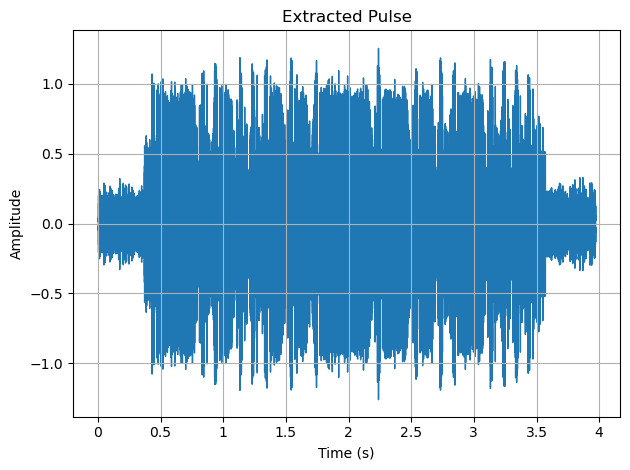

In [27]:
sig = overlap_add(extracted_frames.T, frame_length, hop_length)
lb.display.waveshow(sig, sr=sr,axis='s')
plt.title('Extracted Pulse')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()